<a href="https://colab.research.google.com/github/ps-research/Optimizing-IoT-Workloads-for-Minimal-Time-and-Energy-with-UAV-Networks-using-Deep-Q-Network/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install prettytable --quiet

In [ ]:
import numpy as np
from prettytable import PrettyTable

# Defining the elements


## IOTs

In [ ]:
class IoTDevice:
    def __init__(self, device_id, computation_frequency, power, noise, channel_gain, chip_coefficient, uav_id):
        self.device_id = device_id
        self.computation_frequency = computation_frequency
        self.power = power
        self.noise = noise
        self.channel_gain = channel_gain
        self.chip_coefficient = chip_coefficient
        self.uav_id = uav_id
        self.task_data_size = None
        self.task_computation_needed = None

    def assign_task(self, data_size, computation_needed):
        self.task_data_size = data_size
        self.task_computation_needed = computation_needed

## UAVs

In [ ]:
class UAV:
    def __init__(self, uav_id, computation_frequency, chip_coefficient, power, channel_gain, noise):
        self.uav_id = uav_id
        self.computation_frequency = computation_frequency
        self.chip_coefficient = chip_coefficient
        self.power = power
        self.channel_gain = channel_gain  # Adding channel_gain attribute
        self.noise = noise                # Adding noise attribute

## Cloud Server

In [ ]:
class CloudServer:
    def __init__(self, cloud_id, computation_frequency, chip_coefficient, power, channel_gain, noise):
        self.cloud_id = cloud_id
        self.computation_frequency = computation_frequency
        self.chip_coefficient = chip_coefficient
        self.power = power
        self.channel_gain = channel_gain  # Adding channel_gain attribute
        self.noise = noise   # Adding noise attribute

## Subtask Deployment Matrix

In [ ]:
class DeploymentDecision:
    def __init__(self, num_iot_devices, num_uavs, num_cloud_servers):
        self.num_iot_devices = num_iot_devices
        self.num_uavs = num_uavs
        self.num_cloud_servers = num_cloud_servers
        self.deployment_matrix = np.zeros((num_iot_devices, 1 + num_uavs + num_cloud_servers))
        self.deployment_matrix[:, 0] = 1  # Default case: all IoT devices do their tasks on their own

    def update(self, iot_device_index, decisions):
        """
        Update the deployment matrix for a given IoT device.

        Parameters:
        - iot_device_index: Index of the IoT device
        - decisions: List of deployment decisions where each element corresponds to the fraction of the task
          assigned to IoT device itself, UAVs, and cloud servers. The length of this list should be equal to the number of columns
          in the matrix.
        """
        if len(decisions) != self.deployment_matrix.shape[1]:
            raise ValueError("The length of decisions list does not match the number of columns in the deployment matrix.")
        self.deployment_matrix[iot_device_index, :] = decisions

    def get_matrix(self):
        return self.deployment_matrix

## Transmission Bandwidth

In [ ]:
class TransmissionBandwidth:
    def __init__(self, num_iot_devices, num_uavs, num_cloud_servers):
        self.bandwidth_matrix_iot_uav = np.zeros((num_iot_devices, num_uavs))
        self.bandwidth_matrix_uav_cloud = np.zeros((num_uavs, num_cloud_servers))
        self.bandwidth_matrix_uav_uav = np.zeros((num_uavs, num_uavs))

    def update_iot_uav(self, iot_device_index, uav_index, bandwidth):
        self.bandwidth_matrix_iot_uav[iot_device_index, uav_index] = bandwidth

    def update_uav_cloud(self, uav_index, cloud_server_index, bandwidth):
        self.bandwidth_matrix_uav_cloud[uav_index, cloud_server_index] = bandwidth

    def update_uav_uav(self, source_uav_index, target_uav_index, bandwidth):
        self.bandwidth_matrix_uav_uav[source_uav_index, target_uav_index] = bandwidth

    def get_bandwidth_iot_uav(self, iot_device_index, uav_index):
        return self.bandwidth_matrix_iot_uav[iot_device_index, uav_index]

    def get_bandwidth_uav_cloud(self, uav_index, cloud_server_index):
        return self.bandwidth_matrix_uav_cloud[uav_index, cloud_server_index]

    def get_bandwidth_uav_uav(self, source_uav_index, target_uav_index):
        return self.bandwidth_matrix_uav_uav[source_uav_index, target_uav_index]

# Models

## Network Model

In [ ]:
class NetworkModel:
    def __init__(self, num_iot_devices, num_uavs, num_cloud_servers, alpha, beta):
        self.num_iot_devices = num_iot_devices
        self.num_uavs = num_uavs
        self.num_cloud_servers = num_cloud_servers
        self.Gamma = np.zeros(num_iot_devices)  # Binary service deployment decision
        self.deployment_decision = DeploymentDecision(num_iot_devices, num_uavs, num_cloud_servers)
        self.transmission_bandwidth = TransmissionBandwidth(num_iot_devices, num_uavs, num_cloud_servers)
        self.transmission_model = TransmissionModel(self.transmission_bandwidth)
        self.execution_model = ExecutionModel(self.deployment_decision)
        self.upload_model = UploadModel(self.deployment_decision, self.transmission_model)
        self.neighboring_uav_execution_model = NeighboringUAVExecutionModel(self.deployment_decision, self.transmission_model, self.execution_model, self.upload_model)
        self.cloud_execution_model = CloudExecutionModel(self.deployment_decision, self.transmission_model, self.execution_model, self.upload_model)
        self.objective_function = ObjectiveFunction(alpha, beta)

    def update_service_decision(self, iot_device_index, decision):
        self.Gamma[iot_device_index] = decision
        if decision == 0:
            self.deployment_decision.update(iot_device_index, [1] + [0] * (self.num_uavs + self.num_cloud_servers))

    def update_transmission_bandwidth_iot_uav(self, iot_device_index, uav_index, bandwidth):
        self.transmission_bandwidth.update_iot_uav(iot_device_index, uav_index, bandwidth)

    def update_transmission_bandwidth_uav_cloud(self, uav_index, cloud_server_index, bandwidth):
        self.transmission_bandwidth.update_uav_cloud(uav_index, cloud_server_index, bandwidth)

    def update_transmission_bandwidth_uav_uav(self, source_uav_index, target_uav_index, bandwidth):
        self.transmission_bandwidth.update_uav_uav(source_uav_index, target_uav_index, bandwidth)

    def get_service_decision(self):
        return self.Gamma

    def get_deployment_matrix(self):
        return self.deployment_decision.get_matrix()

    def compute_objective(self, iot_devices, uavs, cloud_servers):
        return self.objective_function.compute_objective(iot_devices, uavs, cloud_servers, self)

    def check_constraints(self):
        transmission_bandwidth_iot_uav = self.transmission_bandwidth.bandwidth_matrix_iot_uav
        transmission_bandwidth_uav_cloud = self.transmission_bandwidth.bandwidth_matrix_uav_cloud
        transmission_bandwidth_uav_uav = self.transmission_bandwidth.bandwidth_matrix_uav_uav
        computation_frequencies = []
        for i in range(self.num_iot_devices):
            computation_frequencies.append(self.deployment_decision.computation_frequency(i))
        return self.objective_function.check_constraints(transmission_bandwidth_iot_uav, transmission_bandwidth_uav_cloud, transmission_bandwidth_uav_uav, computation_frequencies)

## Transmission Model

In [ ]:
class TransmissionModel:
    def __init__(self, transmission_bandwidth):
        self.transmission_bandwidth = transmission_bandwidth

    def transmission_rate_iot_uav(self, iot_device, uav_index):
        bandwidth = self.transmission_bandwidth.get_bandwidth_iot_uav(iot_device.device_id, uav_index)
        return bandwidth * np.log2(1 + (iot_device.power * iot_device.channel_gain) / iot_device.noise)

    def transmission_rate_uav_cloud(self, uav, cloud_server):
        bandwidth = self.transmission_bandwidth.get_bandwidth_uav_cloud(uav.uav_id, cloud_server.cloud_id)
        return bandwidth * np.log2(1 + (uav.power * uav.channel_gain) / uav.noise)

    def transmission_rate_uav_uav(self, source_uav, target_uav):
        bandwidth = self.transmission_bandwidth.get_bandwidth_uav_uav(source_uav.uav_id, target_uav.uav_id)
        return bandwidth * np.log2(1 + (source_uav.power * source_uav.channel_gain) / source_uav.noise)

## Execution Model

In [ ]:
class ExecutionModel:
    def __init__(self, deployment_decision):
        self.deployment_decision = deployment_decision

    def local_execution_delay(self, iot_device_index, iot_device):
        if iot_device.task_data_size is None or iot_device.task_computation_needed is None:
            raise ValueError("Task data size and computation needed must be assigned to the IoT device.")

        gamma_i_m = deployment_decision.get_matrix()[iot_device_index, 0]
        return (gamma_i_m * iot_device.task_data_size * iot_device.task_computation_needed) / iot_device.computation_frequency

    def local_execution_energy(self, iot_device_index, iot_device):
        if iot_device.task_data_size is None or iot_device.task_computation_needed is None:
            raise ValueError("Task data size and computation needed must be assigned to the IoT device.")

        gamma_i_m = deployment_decision.get_matrix()[iot_device_index, 0]
        return (gamma_i_m * iot_device.task_data_size * iot_device.task_computation_needed * iot_device.chip_coefficient *
                (iot_device.computation_frequency * iot_device.computation_frequency))

    def uav_execution_delay(self, iot_device_index, iot_device, uav):
        if iot_device.task_data_size is None or iot_device.task_computation_needed is None:
            raise ValueError("Task data size and computation needed must be assigned to the IoT device.")

        gamma_i_u = deployment_decision.get_matrix()[iot_device_index, uav.uav_id + 1]
        return (gamma_i_u * iot_device.task_data_size * iot_device.task_computation_needed) / uav.computation_frequency

    def uav_execution_energy(self, iot_device_index, iot_device, uav):
        if iot_device.task_data_size is None or iot_device.task_computation_needed is None:
            raise ValueError("Task data size and computation needed must be assigned to the IoT device.")

        gamma_i_u = deployment_decision.get_matrix()[iot_device_index, uav.uav_id + 1]
        return (gamma_i_u * iot_device.task_data_size * iot_device.task_computation_needed * uav.chip_coefficient *
                (uav.computation_frequency * uav.computation_frequency))

    def cloud_execution_delay(self, iot_device_index, iot_device, cloud_server):
        if iot_device.task_data_size is None or iot_device.task_computation_needed is None:
            raise ValueError("Task data size and computation needed must be assigned to the IoT device.")

        gamma_i_c = deployment_decision.get_matrix()[iot_device_index, cloud_server.cloud_id + 1 + self.deployment_decision.num_uavs]
        return (gamma_i_c * iot_device.task_data_size * iot_device.task_computation_needed) / cloud_server.computation_frequency

    def cloud_execution_energy(self, iot_device_index, iot_device, cloud_server):
        if iot_device.task_data_size is None or iot_device.task_computation_needed is None:
            raise ValueError("Task data size and computation needed must be assigned to the IoT device.")

        gamma_i_c = deployment_decision.get_matrix()[iot_device_index, cloud_server.cloud_id + 1 + self.deployment_decision.num_uavs]
        return (gamma_i_c * iot_device.task_data_size * iot_device.task_computation_needed * cloud_server.chip_coefficient *
                (cloud_server.computation_frequency * cloud_server.computation_frequency))

## Upload Model

In [ ]:
class UploadModel:
    def __init__(self, deployment_decision, transmission_model):
        self.deployment_decision = deployment_decision
        self.transmission_model = transmission_model

    def uav_upload_delay(self, iot_device_index, iot_device):
        if iot_device.task_data_size is None:
            raise ValueError("Task data size must be assigned to the IoT device.")

        # Ensure that the IoT device is uploading to its associated UAV
        if iot_device.uav_id != iot_device.uav_id:
            raise ValueError("IoT device is not uploading to its associated UAV.")

        gamma_i_u = deployment_decision.get_matrix()[iot_device_index, iot_device.uav_id + 1]
        transmission_rate = self.transmission_model.transmission_rate_iot_uav(iot_device, iot_device.uav_id)
        return (gamma_i_u * iot_device.task_data_size) / transmission_rate

    def uav_upload_energy(self, iot_device_index, iot_device, uav):
        if iot_device.task_data_size is None:
            raise ValueError("Task data size must be assigned to the IoT device.")

        # Ensure that the IoT device is uploading to its associated UAV
        if iot_device.uav_id != uav.uav_id:
            raise ValueError("IoT device is not uploading to its associated UAV.")

        gamma_i_u = deployment_decision.get_matrix()[iot_device_index, uav.uav_id + 1]
        transmission_rate = self.transmission_model.transmission_rate_iot_uav(iot_device, uav.uav_id)
        return (gamma_i_u * iot_device.task_data_size * uav.power) / transmission_rate

## Neighboring UAV model

In [ ]:
class NeighboringUAVExecutionModel:
    def __init__(self, deployment_decision, transmission_model, execution_model, upload_model):
        self.deployment_decision = deployment_decision
        self.transmission_model = transmission_model
        self.execution_model = execution_model
        self.upload_model = upload_model

    def upload_delay_uav_to_uav(self, source_uav, target_uav, iot_device):
        transmission_rate = self.transmission_model.transmission_rate_uav_uav(source_uav, target_uav)
        gamma_i_uv = deployment_decision.get_matrix()[iot_device.device_id, target_uav.uav_id + 1]
        return (gamma_i_uv * iot_device.task_data_size) / transmission_rate

    def upload_energy_uav_to_uav(self, source_uav, target_uav, iot_device):
        transmission_rate = self.transmission_model.transmission_rate_uav_uav(source_uav, target_uav)
        gamma_i_uv = deployment_decision.get_matrix()[iot_device.device_id, target_uav.uav_id + 1]
        return (gamma_i_uv * iot_device.task_data_size * source_uav.power) / transmission_rate

    def neighboring_uav_execution_delay(self, iot_device, uav, neighbor_uav):
        T_upload_m_u = self.upload_model.uav_upload_delay(iot_device.device_id, iot_device)
        T_upload_u_v = self.upload_delay_uav_to_uav(uav, neighbor_uav, iot_device)
        T_UAV_i_v = self.execution_model.uav_execution_delay(iot_device.device_id, iot_device, neighbor_uav)
        return T_upload_m_u + T_upload_u_v + T_UAV_i_v

    def neighboring_uav_execution_energy(self, iot_device, uav, neighbor_uav):
        E_upload_m_u = self.upload_model.uav_upload_energy(iot_device.device_id, iot_device, uav)
        E_upload_u_v = self.upload_energy_uav_to_uav(uav, neighbor_uav, iot_device)
        E_UAV_i_v = self.execution_model.uav_execution_energy(iot_device.device_id, iot_device, neighbor_uav)
        return E_upload_m_u + E_upload_u_v + E_UAV_i_v

## Cloud Execution

In [ ]:
class CloudExecutionModel:
    def __init__(self, deployment_decision, transmission_model, execution_model, upload_model):
        self.deployment_decision = deployment_decision
        self.transmission_model = transmission_model
        self.execution_model = execution_model
        self.upload_model = upload_model

    def upload_delay_uav_to_cloud(self, uav, cloud_server, iot_device):
        transmission_rate = self.transmission_model.transmission_rate_uav_cloud(uav, cloud_server)
        gamma_i_uc = deployment_decision.get_matrix()[iot_device.device_id, cloud_server.cloud_id + 1 + self.deployment_decision.num_uavs]
        return (gamma_i_uc * iot_device.task_data_size) / transmission_rate

    def upload_energy_uav_to_cloud(self, uav, cloud_server, iot_device):
        transmission_rate = self.transmission_model.transmission_rate_uav_cloud(uav, cloud_server)
        gamma_i_uc = deployment_decision.get_matrix()[iot_device.device_id, cloud_server.cloud_id + 1 + self.deployment_decision.num_uavs]
        return (gamma_i_uc * iot_device.task_data_size * uav.power) / transmission_rate

    def cloud_execution_delay(self, iot_device, uav, cloud_server):
        T_upload_m_u = self.upload_model.uav_upload_delay(iot_device.device_id, iot_device)
        T_upload_u_c = self.upload_delay_uav_to_cloud(uav, cloud_server, iot_device)
        T_cloud_i_c = self.execution_model.cloud_execution_delay(iot_device.device_id, iot_device, cloud_server)
        return T_upload_m_u + T_upload_u_c + T_cloud_i_c

    def cloud_execution_energy(self, iot_device, uav, cloud_server):
        E_upload_m_u = self.upload_model.uav_upload_energy(iot_device.device_id, iot_device, uav)
        E_upload_u_c = self.upload_energy_uav_to_cloud(uav, cloud_server, iot_device)
        E_cloud_i_c = self.execution_model.cloud_execution_energy(iot_device.device_id, iot_device, cloud_server)
        return E_upload_m_u + E_upload_u_c + E_cloud_i_c

# OBJECTIVE FUNCTION

In [ ]:
class ObjectiveFunction:
    def __init__(self, alpha, beta):
        self.alpha = alpha  # Weighting coefficient for energy
        self.beta = beta    # Weighting coefficient for delay

    def compute_total_delay(self, iot_devices, uavs, cloud_servers, network_model):
        total_delay = 0  # Initialize total delay to zero
        for iot_device in iot_devices:
            iot_device_id = iot_device.device_id
            associated_uav = uavs[iot_device.uav_id]

            # Calculate local execution delay for the IoT device
            local_delay = network_model.execution_model.local_execution_delay(iot_device_id, iot_device)

            # Calculate the delay for uploading to and executing on the associated UAV
            uav_upload_delay = network_model.upload_model.uav_upload_delay(iot_device_id, iot_device)
            uav_execution_delay = network_model.execution_model.uav_execution_delay(iot_device_id, iot_device, associated_uav)
            associated_uav_delay = uav_upload_delay + uav_execution_delay

            # Calculate the delay for uploading to and executing on neighboring UAVs
            neighboring_uav_delay = uav_upload_delay  # Initialize with the delay for uploading to the associated UAV
            for neighbor_uav in uavs:
                if neighbor_uav.uav_id != associated_uav.uav_id:
                    # Calculate the upload delay from the associated UAV to the neighboring UAV
                    neighbor_upload_delay = network_model.neighboring_uav_execution_model.upload_delay_uav_to_uav(associated_uav, neighbor_uav, iot_device)
                    # Calculate the execution delay on the neighboring UAV
                    neighbor_execution_delay = network_model.neighboring_uav_execution_model.neighboring_uav_execution_delay(iot_device, associated_uav, neighbor_uav)
                    neighboring_uav_delay += neighbor_upload_delay + neighbor_execution_delay

            # Calculate the delay for uploading to and executing on cloud servers
            cloud_execution_delay = uav_upload_delay  # Initialize with the delay for uploading to the associated UAV
            for cloud_server in cloud_servers:
                # Calculate the upload delay from the associated UAV to the cloud server
                upload_delay_uav_to_cloud = network_model.cloud_execution_model.upload_delay_uav_to_cloud(associated_uav, cloud_server, iot_device)
                # Calculate the execution delay on the cloud server
                execution_delay_cloud = network_model.cloud_execution_model.cloud_execution_delay(iot_device, associated_uav, cloud_server)
                cloud_execution_delay += upload_delay_uav_to_cloud + execution_delay_cloud

            # Sum up all delays for the IoT device
            total_delay += local_delay + associated_uav_delay + neighboring_uav_delay + cloud_execution_delay

        return total_delay  # Return the total delay for all IoT devices

    def compute_total_energy(self, iot_devices, uavs, cloud_servers, network_model):
        total_energy = 0  # Initialize total energy to zero
        for iot_device in iot_devices:
            iot_device_id = iot_device.device_id
            associated_uav = uavs[iot_device.uav_id]

            # Calculate local execution energy for the IoT device
            local_energy = network_model.execution_model.local_execution_energy(iot_device_id, iot_device)

            # Calculate the energy for uploading to and executing on the associated UAV
            uav_upload_energy = network_model.upload_model.uav_upload_energy(iot_device_id, iot_device, associated_uav)
            uav_execution_energy = network_model.execution_model.uav_execution_energy(iot_device_id, iot_device, associated_uav)
            associated_uav_energy = uav_upload_energy + uav_execution_energy

            # Calculate the energy for uploading to and executing on neighboring UAVs
            neighboring_uav_energy = uav_upload_energy  # Initialize with the energy for uploading to the associated UAV
            for neighbor_uav in uavs:
                if neighbor_uav.uav_id != associated_uav.uav_id:
                    # Calculate the upload energy from the associated UAV to the neighboring UAV
                    neighbor_upload_energy = network_model.neighboring_uav_execution_model.upload_energy_uav_to_uav(associated_uav, neighbor_uav, iot_device)
                    # Calculate the execution energy on the neighboring UAV
                    neighbor_execution_energy = network_model.neighboring_uav_execution_model.neighboring_uav_execution_energy(iot_device, associated_uav, neighbor_uav)
                    neighboring_uav_energy += neighbor_upload_energy + neighbor_execution_energy

            # Calculate the energy for uploading to and executing on cloud servers
            cloud_execution_energy = uav_upload_energy  # Initialize with the energy for uploading to the associated UAV
            for cloud_server in cloud_servers:
                # Calculate the upload energy from the associated UAV to the cloud server
                upload_energy_uav_to_cloud = network_model.cloud_execution_model.upload_energy_uav_to_cloud(associated_uav, cloud_server, iot_device)
                # Calculate the execution energy on the cloud server
                execution_energy_cloud = network_model.cloud_execution_model.cloud_execution_energy(iot_device, iot_device, cloud_server)
                cloud_execution_energy += upload_energy_uav_to_cloud + execution_energy_cloud

            # Sum up all energies for the IoT device
            total_energy += local_energy + associated_uav_energy + neighboring_uav_energy + cloud_execution_energy

        return total_energy  # Return the total energy for all IoT devices

    def compute_objective(self, iot_devices, uavs, cloud_servers, network_model):
        # Compute the total delay and total energy for all IoT devices
        total_delay = self.compute_total_delay(iot_devices, uavs, cloud_servers, network_model)
        total_energy = self.compute_total_energy(iot_devices, uavs, cloud_servers, network_model)
        # Compute the objective function as a weighted sum of total energy and total delay
        return self.alpha * total_energy + self.beta * total_delay

# Example Scenario

In [ ]:
# INITIALIZE THE SCENARIO
NUM_IOT   = 12
NUM_UAV   = 6
NUM_CLOUD = 2

In [ ]:
# Initialize IoT devices
iot_devices = []
for i in range(NUM_IOT):
    uav_id = i // (NUM_IOT // NUM_UAV)  # Each UAV is associated with an equal number of IoT devices
    iot_device = IoTDevice(
        device_id=i,
        computation_frequency=1e8,  # Example value for computation frequency
        power=0.1,                  # Example value for power
        noise=1e-9,                 # Example value for noise
        channel_gain=1.2,           # Example value for channel gain
        chip_coefficient=1e-23,     # Example value for chip coefficient
        uav_id=uav_id
    )
    iot_devices.append(iot_device)

# Initialize UAVs
uavs = []
for i in range(NUM_UAV):
    uav = UAV(
        uav_id=i,
        computation_frequency=3e9,  # Example value for computation frequency
        chip_coefficient=1e-27,     # Example value for chip coefficient
        power=0.5,                  # Example value for power
        channel_gain=1.0,           # Example value for channel gain
        noise=1e-9                  # Example value for noise
    )
    uavs.append(uav)

# Initialize Cloud Servers
cloud_servers = []
for i in range(NUM_CLOUD):
    cloud_server = CloudServer(
        cloud_id=i,
        computation_frequency=10e9,   # Example value for computation frequency
        chip_coefficient = 1e-27,
        power = 0.5,
        channel_gain = 1.0,
        noise = 1e-9

    )
    cloud_servers.append(cloud_server)

# Initialize network model with alpha and beta for the objective function
network_model = NetworkModel(
    num_iot_devices=NUM_IOT,
    num_uavs=NUM_UAV,
    num_cloud_servers=NUM_CLOUD,
    alpha=0.1,
    beta=0.9
)

# Assign tasks to IoT devices (Example: data size = 1e6, computation needed = 5e8)
for iot_device in iot_devices:
    iot_device.assign_task(data_size=1e6, computation_needed=5e8)

In [ ]:
# Initialize transmission bandwidths
for i in range(NUM_IOT):
    for j in range(NUM_UAV):
        # Bandwidth from IoT device to its associated UAV
        if i // (NUM_IOT // NUM_UAV) == j:
            network_model.update_transmission_bandwidth_iot_uav(i, j, bandwidth=5e7)  # 50 Mbps
        else:
            network_model.update_transmission_bandwidth_iot_uav(i, j, bandwidth=2e7)  # 20 Mbps

for j in range(NUM_UAV):
    for k in range(NUM_CLOUD):
        # Bandwidth from UAV to cloud server
        network_model.update_transmission_bandwidth_uav_cloud(j, k, bandwidth=1e9)  # 1 Gbps

for j in range(NUM_UAV):
    for k in range(NUM_UAV):
        if j != k:
            # Bandwidth between UAVs
            network_model.update_transmission_bandwidth_uav_uav(j, k, bandwidth=2e8)  # 200 Mbps

In [ ]:
from prettytable import PrettyTable

# Function to print IoT devices information
def print_iot_devices(iot_devices):
    table = PrettyTable()
    table.field_names = ["IoT Device ID", "Computation Frequency (Hz)", "Power (W)", "Noise (W)", "Channel Gain", "Chip Coefficient", "Associated UAV ID","Task Data size(Oi)","Task Computation Needed (Di)"]

    for device in iot_devices:
        table.add_row([
            device.device_id,
            device.computation_frequency,
            device.power,
            device.noise,
            device.channel_gain,
            device.chip_coefficient,
            device.uav_id,
            device.task_data_size,
            device.task_computation_needed

        ])

    print("IoT Devices Information")
    print(table)

# Function to print UAVs information
def print_uavs(uavs):
    table = PrettyTable()
    table.field_names = ["UAV ID", "Computation Frequency (Hz)", "Chip Coefficient", "Power (W)", "Channel Gain", "Noise (W)"]

    for uav in uavs:
        table.add_row([
            uav.uav_id,
            uav.computation_frequency,
            uav.chip_coefficient,
            uav.power,
            uav.channel_gain,
            uav.noise
        ])

    print("UAVs Information")
    print(table)

# Function to print Cloud Servers information
def print_cloud_servers(cloud_servers):
    table = PrettyTable()
    table.field_names = ["Cloud Server ID", "Computation Frequency (Hz)", "Chip Coefficient"]

    for server in cloud_servers:
        table.add_row([
            server.cloud_id,
            server.computation_frequency,
            server.chip_coefficient
        ])

    print("Cloud Servers Information")
    print(table)

In [ ]:
# Print all device information
print_iot_devices(iot_devices)

IoT Devices Information
+---------------+----------------------------+-----------+-----------+--------------+------------------+-------------------+--------------------+------------------------------+
| IoT Device ID | Computation Frequency (Hz) | Power (W) | Noise (W) | Channel Gain | Chip Coefficient | Associated UAV ID | Task Data size(Oi) | Task Computation Needed (Di) |
+---------------+----------------------------+-----------+-----------+--------------+------------------+-------------------+--------------------+------------------------------+
|       0       |        100000000.0         |    0.1    |   1e-09   |     1.2      |      1e-23       |         0         |     1000000.0      |         500000000.0          |
|       1       |        100000000.0         |    0.1    |   1e-09   |     1.2      |      1e-23       |         0         |     1000000.0      |         500000000.0          |
|       2       |        100000000.0         |    0.1    |   1e-09   |     1.2      |      

In [ ]:
print_uavs(uavs)

UAVs Information
+--------+----------------------------+------------------+-----------+--------------+-----------+
| UAV ID | Computation Frequency (Hz) | Chip Coefficient | Power (W) | Channel Gain | Noise (W) |
+--------+----------------------------+------------------+-----------+--------------+-----------+
|   0    |        3000000000.0        |      1e-27       |    0.5    |     1.0      |   1e-09   |
|   1    |        3000000000.0        |      1e-27       |    0.5    |     1.0      |   1e-09   |
|   2    |        3000000000.0        |      1e-27       |    0.5    |     1.0      |   1e-09   |
|   3    |        3000000000.0        |      1e-27       |    0.5    |     1.0      |   1e-09   |
|   4    |        3000000000.0        |      1e-27       |    0.5    |     1.0      |   1e-09   |
|   5    |        3000000000.0        |      1e-27       |    0.5    |     1.0      |   1e-09   |
+--------+----------------------------+------------------+-----------+--------------+-----------+


In [ ]:
print_cloud_servers(cloud_servers)

Cloud Servers Information
+-----------------+----------------------------+------------------+
| Cloud Server ID | Computation Frequency (Hz) | Chip Coefficient |
+-----------------+----------------------------+------------------+
|        0        |       10000000000.0        |      1e-27       |
|        1        |       10000000000.0        |      1e-27       |
+-----------------+----------------------------+------------------+


In [ ]:
from prettytable import PrettyTable

# Function to print IoT to UAV bandwidths
def print_bandwidth_iot_uav(transmission_bandwidth):
    table = PrettyTable()
    table.field_names = ["IoT Device ID", "UAV ID", "Bandwidth (bps)"]

    for i in range(transmission_bandwidth.bandwidth_matrix_iot_uav.shape[0]):
        for j in range(transmission_bandwidth.bandwidth_matrix_iot_uav.shape[1]):
            table.add_row([
                i,
                j,
                transmission_bandwidth.get_bandwidth_iot_uav(i, j)
            ])

    print("IoT to UAV Bandwidths")
    print(table)

# Function to print UAV to Cloud bandwidths
def print_bandwidth_uav_cloud(transmission_bandwidth):
    table = PrettyTable()
    table.field_names = ["UAV ID", "Cloud Server ID", "Bandwidth (bps)"]

    for i in range(transmission_bandwidth.bandwidth_matrix_uav_cloud.shape[0]):
        for j in range(transmission_bandwidth.bandwidth_matrix_uav_cloud.shape[1]):
            table.add_row([
                i,
                j,
                transmission_bandwidth.get_bandwidth_uav_cloud(i, j)
            ])

    print("UAV to Cloud Bandwidths")
    print(table)

# Function to print UAV to UAV bandwidths
def print_bandwidth_uav_uav(transmission_bandwidth):
    table = PrettyTable()
    table.field_names = ["Source UAV ID", "Target UAV ID", "Bandwidth (bps)"]

    for i in range(transmission_bandwidth.bandwidth_matrix_uav_uav.shape[0]):
        for j in range(transmission_bandwidth.bandwidth_matrix_uav_uav.shape[1]):
            if i != j:  # Exclude self-loops
                table.add_row([
                    i,
                    j,
                    transmission_bandwidth.get_bandwidth_uav_uav(i, j)
                ])

    print("UAV to UAV Bandwidths")
    print(table)

In [ ]:
# Example usage with the initialized transmission bandwidth
print_bandwidth_iot_uav(network_model.transmission_bandwidth)

IoT to UAV Bandwidths
+---------------+--------+-----------------+
| IoT Device ID | UAV ID | Bandwidth (bps) |
+---------------+--------+-----------------+
|       0       |   0    |    50000000.0   |
|       0       |   1    |    20000000.0   |
|       0       |   2    |    20000000.0   |
|       0       |   3    |    20000000.0   |
|       0       |   4    |    20000000.0   |
|       0       |   5    |    20000000.0   |
|       1       |   0    |    50000000.0   |
|       1       |   1    |    20000000.0   |
|       1       |   2    |    20000000.0   |
|       1       |   3    |    20000000.0   |
|       1       |   4    |    20000000.0   |
|       1       |   5    |    20000000.0   |
|       2       |   0    |    20000000.0   |
|       2       |   1    |    50000000.0   |
|       2       |   2    |    20000000.0   |
|       2       |   3    |    20000000.0   |
|       2       |   4    |    20000000.0   |
|       2       |   5    |    20000000.0   |
|       3       |   0    |    200

In [ ]:
print_bandwidth_uav_cloud(network_model.transmission_bandwidth)

UAV to Cloud Bandwidths
+--------+-----------------+-----------------+
| UAV ID | Cloud Server ID | Bandwidth (bps) |
+--------+-----------------+-----------------+
|   0    |        0        |   1000000000.0  |
|   0    |        1        |   1000000000.0  |
|   1    |        0        |   1000000000.0  |
|   1    |        1        |   1000000000.0  |
|   2    |        0        |   1000000000.0  |
|   2    |        1        |   1000000000.0  |
|   3    |        0        |   1000000000.0  |
|   3    |        1        |   1000000000.0  |
|   4    |        0        |   1000000000.0  |
|   4    |        1        |   1000000000.0  |
|   5    |        0        |   1000000000.0  |
|   5    |        1        |   1000000000.0  |
+--------+-----------------+-----------------+


In [ ]:
print_bandwidth_uav_uav(network_model.transmission_bandwidth)

UAV to UAV Bandwidths
+---------------+---------------+-----------------+
| Source UAV ID | Target UAV ID | Bandwidth (bps) |
+---------------+---------------+-----------------+
|       0       |       1       |   200000000.0   |
|       0       |       2       |   200000000.0   |
|       0       |       3       |   200000000.0   |
|       0       |       4       |   200000000.0   |
|       0       |       5       |   200000000.0   |
|       1       |       0       |   200000000.0   |
|       1       |       2       |   200000000.0   |
|       1       |       3       |   200000000.0   |
|       1       |       4       |   200000000.0   |
|       1       |       5       |   200000000.0   |
|       2       |       0       |   200000000.0   |
|       2       |       1       |   200000000.0   |
|       2       |       3       |   200000000.0   |
|       2       |       4       |   200000000.0   |
|       2       |       5       |   200000000.0   |
|       3       |       0       |   200000

In [ ]:
# Initialize DeploymentDecision object
deployment_decision = DeploymentDecision(num_iot_devices=NUM_IOT, num_uavs=NUM_UAV, num_cloud_servers=NUM_CLOUD)

In [ ]:
# Print the subtask deployment matrix
def print_deployment_matrix(deployment_matrix):
    num_iot_devices, num_columns = deployment_matrix.shape
    num_uavs = NUM_UAV  # Number of UAVs
    num_cloud_servers = NUM_CLOUD  # Number of cloud servers

    table = PrettyTable()
    column_names = ["IoT Device ID", "Local Execution"] + [f"UAV {i}" for i in range(num_uavs)] + [f"Cloud Server {i}" for i in range(num_cloud_servers)]
    table.field_names = column_names

    for i in range(num_iot_devices):
        row = [i] + deployment_matrix[i].tolist()
        table.add_row(row)

    print("Subtask Deployment Matrix")
    print(table)

In [ ]:
# Print INITIAL deployment matrix
print_deployment_matrix(deployment_decision.get_matrix())

Subtask Deployment Matrix
+---------------+-----------------+-------+-------+-------+-------+-------+-------+----------------+----------------+
| IoT Device ID | Local Execution | UAV 0 | UAV 1 | UAV 2 | UAV 3 | UAV 4 | UAV 5 | Cloud Server 0 | Cloud Server 1 |
+---------------+-----------------+-------+-------+-------+-------+-------+-------+----------------+----------------+
|       0       |       1.0       |  0.0  |  0.0  |  0.0  |  0.0  |  0.0  |  0.0  |      0.0       |      0.0       |
|       1       |       1.0       |  0.0  |  0.0  |  0.0  |  0.0  |  0.0  |  0.0  |      0.0       |      0.0       |
|       2       |       1.0       |  0.0  |  0.0  |  0.0  |  0.0  |  0.0  |  0.0  |      0.0       |      0.0       |
|       3       |       1.0       |  0.0  |  0.0  |  0.0  |  0.0  |  0.0  |  0.0  |      0.0       |      0.0       |
|       4       |       1.0       |  0.0  |  0.0  |  0.0  |  0.0  |  0.0  |  0.0  |      0.0       |      0.0       |
|       5       |       1.0   

In [ ]:
# # Initialize the subtask deployment matrix with random values using DeploymentDecision class
# def initialize_random_deployment_matrix(deployment_decision):
#     num_iot_devices, num_columns = deployment_decision.get_matrix().shape
#     num_uavs = deployment_decision.num_uavs
#     num_cloud_servers = deployment_decision.num_cloud_servers

#     for i in range(num_iot_devices):
#         total_fraction = 1.0  # Ensure the sum of fractions is 1.0 for each IoT device
#         fractions = np.random.rand(1 + num_uavs + num_cloud_servers)
#         fractions /= fractions.sum()  # Normalize to make sure the sum is 1.0
#         deployment_decision.update(i, fractions.tolist())

In [ ]:
# Initialize random deployment matrix
# initialize_random_deployment_matrix(deployment_decision)

In [ ]:
# Print RANDOMIZED deployment matrix
# print_deployment_matrix(deployment_decision.get_matrix())

In [ ]:
# def initialize_custom_deployment_matrix(deployment_decision):
#     num_iot_devices, num_columns = deployment_decision.get_matrix().shape
#     num_uavs = deployment_decision.num_uavs
#     num_cloud_servers = deployment_decision.num_cloud_servers

#     for i in range(num_iot_devices):
#         fractions = [0] * (1 + num_uavs + num_cloud_servers)  # Initialize with zeros
#         fractions[1] = 1.0  # Set the fraction for the first UAV to 1
#         deployment_decision.update(i, fractions)

In [ ]:
# initialize_custom_deployment_matrix(deployment_decision)

In [ ]:
# Print CUSTOM deployment matrix
# print_deployment_matrix(deployment_decision.get_matrix())

In [ ]:
# Assign the random deployment decision to the network model
network_model.deployment_decision = deployment_decision

In [ ]:
# Compute the total delay
total_delay = network_model.objective_function.compute_total_delay(iot_devices, uavs, cloud_servers, network_model)
print(f"Total Delay: {total_delay}")

Total Delay: 60000000.0


In [ ]:
# Compute the total energy
total_energy = network_model.objective_function.compute_total_energy(iot_devices, uavs, cloud_servers, network_model)
print(f"Total Energy: {total_energy}")

Total Energy: 600000000.0


In [ ]:
# Compute the objective function value
objective_value = network_model.compute_objective(iot_devices, uavs, cloud_servers)
print(f"Objective Function Value: {objective_value}")

Objective Function Value: 114000000.0


# Task Partitioning Algo

In [ ]:
import numpy as np
from copy import deepcopy

class CustomUAVIoTEnv:
    def __init__(self, network_model, iot_devices, uavs, cloud_servers, initial_deployment_matrix=None):
        self.network_model = network_model
        self.iot_devices = iot_devices
        self.uavs = uavs
        self.cloud_servers = cloud_servers

        self.num_iot = len(iot_devices)
        self.num_uavs = len(uavs)
        self.num_clouds = len(cloud_servers)

        # Define action and observation space
        self.observation_shape = (self.num_iot, 1 + self.num_uavs + self.num_clouds)
        self.action_space_size = self.num_iot * (1 + self.num_uavs + self.num_clouds)

        # Set the initial subtask deployment matrix
        if initial_deployment_matrix is not None:
            self.network_model.deployment_decision = initial_deployment_matrix
        else:
            self.network_model.deployment_decision = np.zeros(self.observation_shape)
            self.network_model.deployment_decision[:, 0] = 1  # Default case: all IoT devices do their tasks on their own

        # Logical constraint
        self.initial_local_delay = self.network_model.objective_function.compute_total_delay(iot_devices, uavs, cloud_servers, network_model)
        self.initial_local_energy = self.network_model.objective_function.compute_total_energy(iot_devices, uavs, cloud_servers, network_model)

        # Initial objective function value
        self.previous_obj_value = self.compute_objective()

    def compute_objective(self):
        return self.network_model.compute_objective(self.iot_devices, self.uavs, self.cloud_servers)

    def step(self, action):
        # Decode action
        iot_idx = action // (1 + self.num_uavs + self.num_clouds)
        sub_idx = action % (1 + self.num_uavs + self.num_clouds)

        # Modify the subtask deployment matrix
        new_deployment_matrix = deepcopy(self.network_model.get_deployment_matrix())
        # Ensure the new fraction is valid
        new_deployment_matrix[iot_idx, sub_idx] = np.random.rand()  # Change to a random valid fraction
        new_deployment_matrix[iot_idx, :] /= new_deployment_matrix[iot_idx, :].sum()  # Normalize to sum to 1

        self.network_model.deployment_decision.deployment_matrix = new_deployment_matrix

        # Calculate new objective function value
        new_obj_value = self.compute_objective()

        # Calculate reward
        difference = (self.previous_obj_value - new_obj_value)


        if difference > 0:
            reward = 50
        else:
            reward = -10

        total_delay = self.network_model.objective_function.compute_total_delay(
            self.iot_devices, self.uavs, self.cloud_servers, self.network_model)
        total_energy = self.network_model.objective_function.compute_total_energy(
            self.iot_devices, self.uavs, self.cloud_servers, self.network_model)

        if total_delay > self.initial_local_delay or total_energy > self.initial_local_energy:
            reward = -100  # Penalize heavily if constraint is violated

        # Update initial objective value
        self.initial_obj_value = new_obj_value

        # Check if episode is done
        done = False  # Define your own condition for done

        # Set placeholder for info
        info = {}

        #update the previous objective value per step
        self.previous_obj_value = new_obj_value

        return new_deployment_matrix, reward, done, info

    def reset(self, initial_deployment_matrix=None):
        # Reset the subtask deployment matrix to the initial state if provided
        if initial_deployment_matrix is not None:
            self.network_model.deployment_decision.deployment_matrix = initial_deployment_matrix
        else:
            self.network_model.deployment_decision.deployment_matrix = np.zeros(self.observation_shape)
            self.network_model.deployment_decision.deployment_matrix[:, 0] = 1  # Default case: all IoT devices do their tasks on their own

        self.initial_obj_value = self.compute_objective()

        return self.network_model.get_deployment_matrix()

    def render(self, mode='human', close=False):
        pass  # Implement visualization if needed

    def get_deployment_matrix(self):
        return self.network_model.get_deployment_matrix()

    def sample_action(self):
        return np.random.randint(0, self.action_space_size)

In [ ]:
# # Initialize the custom environment
# env = CustomUAVIoTEnv(network_model, iot_devices, uavs, cloud_servers, deployment_decision)
# obs = env.reset()
# step_count = 0

# for _ in range(10):
#     action = env.sample_action()  # Random action
#     new_state, reward, done, info = env.step(action)
#     step_count += 1
#     print(f"Step: {step_count}, Action: {action}, Reward: {reward}, Done: {done}")
#     print("New state:")
#     print(new_state)

In [ ]:
# !pip install torch --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

In [ ]:
import torch
import torch.nn as nn

class VerySmallDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(VerySmallDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 8)
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(8, 16)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(16, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        return self.fc3(x)


In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, optimizer_name='adam', learning_rate=0.001, gamma=0.99, epsilon_start=0.3, epsilon_end=0.01, epsilon_decay_steps=10000, buffer_size=10000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = epsilon_decay_steps
        self.batch_size = batch_size
        self.step_count = 0

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = VerySmallDQN(state_size, action_size).to(self.device)
        self.target_network = VerySmallDQN(state_size, action_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = self.get_optimizer(optimizer_name, learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def get_optimizer(self, optimizer_name, learning_rate):
        if optimizer_name == 'adam':
            return optim.Adam(self.q_network.parameters(), lr=learning_rate)
        elif optimizer_name == 'sgd':
            return optim.SGD(self.q_network.parameters(), lr=learning_rate)
        elif optimizer_name == 'rmsprop':
            return optim.RMSprop(self.q_network.parameters(), lr=learning_rate)
        elif optimizer_name == 'adagrad':
            return optim.Adagrad(self.q_network.parameters(), lr=learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    def get_epsilon(self):
        if self.step_count >= self.epsilon_decay_steps:
            return self.epsilon_end
        return self.epsilon_start - (self.epsilon_start - self.epsilon_end) * (self.step_count / self.epsilon_decay_steps)

    def select_action(self, state):
        epsilon = self.get_epsilon()
        self.step_count += 1
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state)
            return q_values.argmax().item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)


        states = np.array(states)
        next_states = np.array(next_states)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def dqn_task_provisioning(env, num_episodes, max_steps, update_frequency, optimizer_name):
    state_size = np.prod(env.observation_shape)
    action_size = env.action_space_size

    total_steps = num_episodes * max_steps
    agent = DQNAgent(state_size, action_size, optimizer_name=optimizer_name, epsilon_decay_steps=int(0.5 * total_steps))

    best_reward = float('-inf')
    best_deployment_matrix = None

    rewards_per_episode = []
    delays_per_episode = []
    energy_per_episode = []

    first_episode_rewards = []
    first_episode_delays = []
    first_episode_energy = []

    last_episode_rewards = []
    last_episode_delays = []
    last_episode_energy = []

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        state = state.flatten()  # Flatten the state to 1D array
        total_reward = 0
        cumulative_delay = 0
        cumulative_energy = 0

        for t in range(1, max_steps + 1):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = next_state.flatten()  # Flatten the next_state

            agent.memory.push(state, action, reward, next_state, done)
            agent.train()

            state = next_state
            total_reward += reward

            if t % update_frequency == 0:
                agent.update_target_network()

            current_delay = env.network_model.objective_function.compute_total_delay(env.iot_devices, env.uavs, env.cloud_servers, env.network_model)
            current_energy = env.network_model.objective_function.compute_total_energy(env.iot_devices, env.uavs, env.cloud_servers, env.network_model)

            cumulative_delay += current_delay
            cumulative_energy += current_energy

            # Store step-wise values for first and last episodes
            if episode == 1:
                first_episode_rewards.append(reward)
                first_episode_delays.append(current_delay)
                first_episode_energy.append(current_energy)
            elif episode == num_episodes:
                last_episode_rewards.append(reward)
                last_episode_delays.append(current_delay)
                last_episode_energy.append(current_energy)

            if done:
                break

        avg_reward = total_reward / max_steps
        avg_delay = cumulative_delay / max_steps
        avg_energy = cumulative_energy / max_steps

        rewards_per_episode.append(avg_reward)
        delays_per_episode.append(avg_delay)
        energy_per_episode.append(avg_energy)

        print(f"Episode {episode}/{num_episodes}, Optimizer: {optimizer_name}, Avg Reward: {avg_reward:.2f}, Avg Delay: {avg_delay:.2f}, Avg Energy: {avg_energy:.2f}")

        if total_reward > best_reward:
            best_reward = total_reward
            best_deployment_matrix = env.get_deployment_matrix()

    return rewards_per_episode, delays_per_episode, energy_per_episode, best_deployment_matrix, first_episode_rewards, first_episode_delays, first_episode_energy, last_episode_rewards, last_episode_delays, last_episode_energy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def dqn_task_provisioning(env, num_episodes, max_steps, update_frequency, optimizer_name):
    state_size = np.prod(env.observation_shape)
    action_size = env.action_space_size

    total_steps = num_episodes * max_steps
    agent = DQNAgent(state_size, action_size, optimizer_name=optimizer_name, epsilon_decay_steps=int(0.5 * total_steps))

    best_reward = float('-inf')
    best_deployment_matrix = None

    rewards_per_episode = []
    delays_per_episode = []
    energy_per_episode = []

    all_episode_rewards = []
    all_episode_delays = []
    all_episode_energy = []

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        state = state.flatten()  # Flatten the state to 1D array
        total_reward = 0
        cumulative_delay = 0
        cumulative_energy = 0

        episode_rewards = []
        episode_delays = []
        episode_energy = []

        for t in range(1, max_steps + 1):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = next_state.flatten()  # Flatten the next_state

            agent.memory.push(state, action, reward, next_state, done)
            agent.train()

            state = next_state
            total_reward += reward

            if t % update_frequency == 0:
                agent.update_target_network()

            current_delay = env.network_model.objective_function.compute_total_delay(env.iot_devices, env.uavs, env.cloud_servers, env.network_model)
            current_energy = env.network_model.objective_function.compute_total_energy(env.iot_devices, env.uavs, env.cloud_servers, env.network_model)

            cumulative_delay += current_delay
            cumulative_energy += current_energy

            episode_rewards.append(reward)
            episode_delays.append(current_delay)
            episode_energy.append(current_energy)

            if done:
                break

        avg_reward = total_reward / max_steps
        avg_delay = cumulative_delay / max_steps
        avg_energy = cumulative_energy / max_steps

        rewards_per_episode.append(avg_reward)
        delays_per_episode.append(avg_delay)
        energy_per_episode.append(avg_energy)

        all_episode_rewards.append(episode_rewards)
        all_episode_delays.append(episode_delays)
        all_episode_energy.append(episode_energy)

        print(f"Episode {episode}/{num_episodes}, Optimizer: {optimizer_name}, Avg Reward: {avg_reward:.2f}, Avg Delay: {avg_delay:.2f}, Avg Energy: {avg_energy:.2f}")

        if total_reward > best_reward:
            best_reward = total_reward
            best_deployment_matrix = env.get_deployment_matrix()

    return rewards_per_episode, delays_per_episode, energy_per_episode, all_episode_rewards, all_episode_delays, all_episode_energy



In [ ]:
def evaluate_optimizers(env, num_episodes, max_steps, update_frequency):
    optimizers = ['adam', 'sgd', 'rmsprop', 'adagrad']
    results = {}

    for optimizer in optimizers:
        print(f"\nEvaluating optimizer: {optimizer}")
        rewards, delays, energy, episode_rewards, episode_delays, episode_energy = dqn_task_provisioning(env, num_episodes, max_steps, update_frequency, optimizer)
        results[optimizer] = {
            'rewards': rewards,
            'delays': delays,
            'energy': energy,
            'episode_rewards': episode_rewards,
            'episode_delays': episode_delays,
            'episode_energy': episode_energy
        }
        env.reset()  # Reset the environment after each optimizer's training

    return results

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def plot_least_combined_episode(results, num_episodes, filename_prefix, starting_value):
    marker_size = 20  # Increased marker size
    label_size = 20  # Increased label size
    legend_size = 20  # Increased legend size
    tick_size = 20   # Increased tick size

    # Find the episode with the least summation of 0.2 * Energy + 0.8 * Delay for SGD optimizer
    def find_min_episode(energy_data, delay_data):
        min_val = np.inf
        min_episode = 0
        for i in range(num_episodes):
            combined_value = 0.2 * energy_data[i] + 0.8 * delay_data[i]
            if combined_value < min_val:
                min_val = combined_value
                min_episode = i
        return min_episode

    min_combined_episode_sgd = find_min_episode(results['adam']['energy'], results['adam']['delays'])

    # Colors and linestyles for differentiating optimizers
    color_styles = {
        'adam': ('blue', '-'),
        'sgd': ('orange', '-'),
        'rmsprop': ('green', '-'),
        'adagrad': ('red', '-')
    }

    # Plot Delay per step for all optimizers for the episode with least combined value for SGD
    plt.figure(figsize=(12, 8))
    for optimizer in results.keys():
        color, linestyle = color_styles[optimizer]
        delays = results[optimizer]['episode_delays'][min_combined_episode_sgd]
        plt.plot(range(len(delays)), delays, label=f'{optimizer}', color=color, linewidth=2, linestyle=linestyle)
    plt.xlabel('Step', fontsize=label_size)
    plt.ylabel('Delay', fontsize=label_size)
    plt.title('Delay per Step', fontsize=24)
    plt.legend(loc='upper right', fontsize=legend_size)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_delay_per_step.pdf', format='pdf', dpi=1000)
    plt.show()

    # Plot Energy per step for all optimizers for the episode with least combined value for SGD
    plt.figure(figsize=(12, 8))
    for optimizer in results.keys():
        color, linestyle = color_styles[optimizer]
        energy = results[optimizer]['episode_energy'][min_combined_episode_sgd]
        plt.plot(range(len(energy)), energy, label=f'{optimizer}', color=color, linewidth=2, linestyle=linestyle)
    plt.xlabel('Step', fontsize=label_size)
    plt.ylabel('Energy', fontsize=label_size)
    plt.title('Energy per Step', fontsize=24)
    plt.legend(loc='upper right', fontsize=legend_size)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_energy_per_step.pdf', format='pdf', dpi=1000)
    plt.show()

In [ ]:
# Usage
env = CustomUAVIoTEnv(network_model, iot_devices, uavs, cloud_servers, deployment_decision)

num_episodes = 10
max_steps = 30000
update_frequency = 150

In [ ]:
optimizer_results = evaluate_optimizers(env, num_episodes, max_steps, update_frequency)


Evaluating optimizer: adam
Episode 1/10, Optimizer: adam, Avg Reward: 26.65, Avg Delay: 7776506.35, Avg Energy: 212093701.09
Episode 2/10, Optimizer: adam, Avg Reward: 26.85, Avg Delay: 6509354.29, Avg Energy: 183639636.93
Episode 3/10, Optimizer: adam, Avg Reward: 26.39, Avg Delay: 6172280.29, Avg Energy: 181195702.83
Episode 4/10, Optimizer: adam, Avg Reward: 25.62, Avg Delay: 6165773.25, Avg Energy: 174151957.15
Episode 5/10, Optimizer: adam, Avg Reward: 24.86, Avg Delay: 5209464.15, Avg Energy: 160535736.46
Episode 6/10, Optimizer: adam, Avg Reward: 23.92, Avg Delay: 6872897.37, Avg Energy: 175830858.89
Episode 7/10, Optimizer: adam, Avg Reward: 24.22, Avg Delay: 6374564.48, Avg Energy: 163017978.79
Episode 8/10, Optimizer: adam, Avg Reward: 24.68, Avg Delay: 4769577.14, Avg Energy: 140546957.79
Episode 9/10, Optimizer: adam, Avg Reward: 24.05, Avg Delay: 5161855.09, Avg Energy: 140617458.09
Episode 10/10, Optimizer: adam, Avg Reward: 24.59, Avg Delay: 6194904.33, Avg Energy: 1505

In [ ]:
optimizer_results['sgd']['energy']

[226362187.74873143,
 234310339.9131353,
 237702067.9769077,
 233507102.64456475,
 247265851.64528224,
 262893088.19471687,
 267843409.60175702,
 287537819.0495727,
 273627375.8244532,
 313229776.3869632]

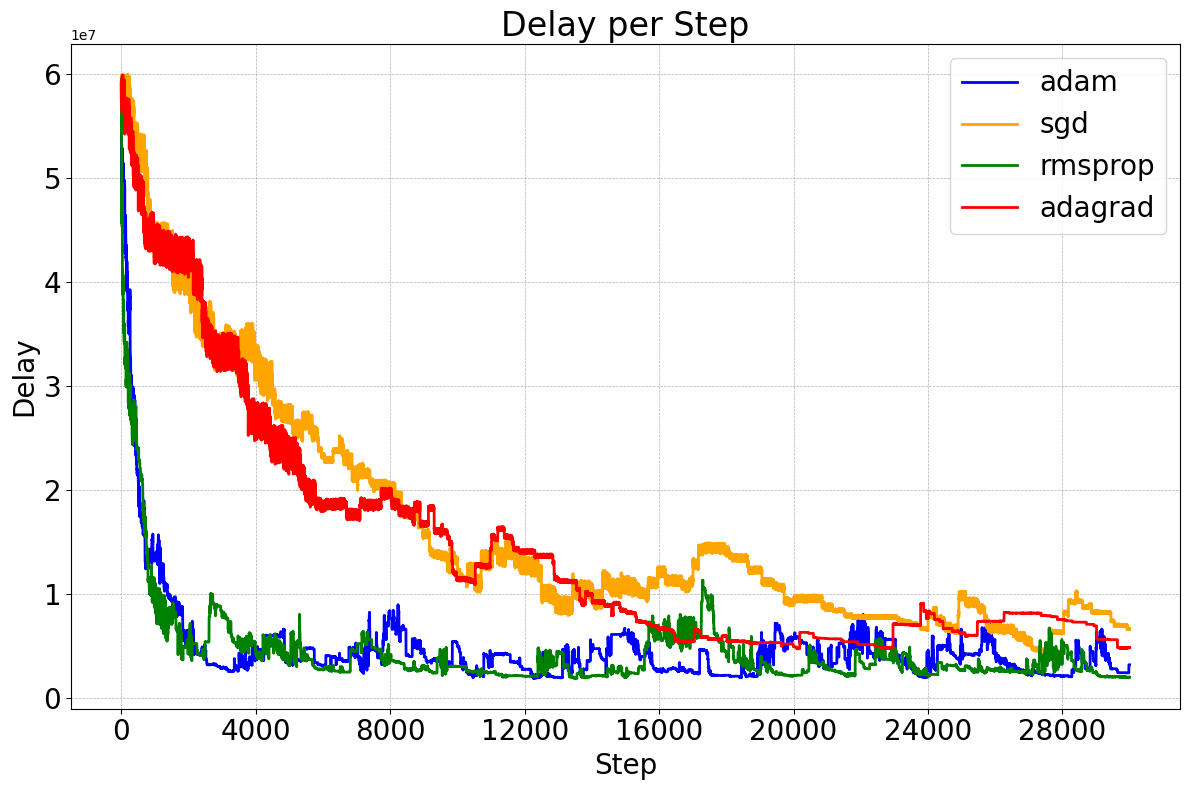

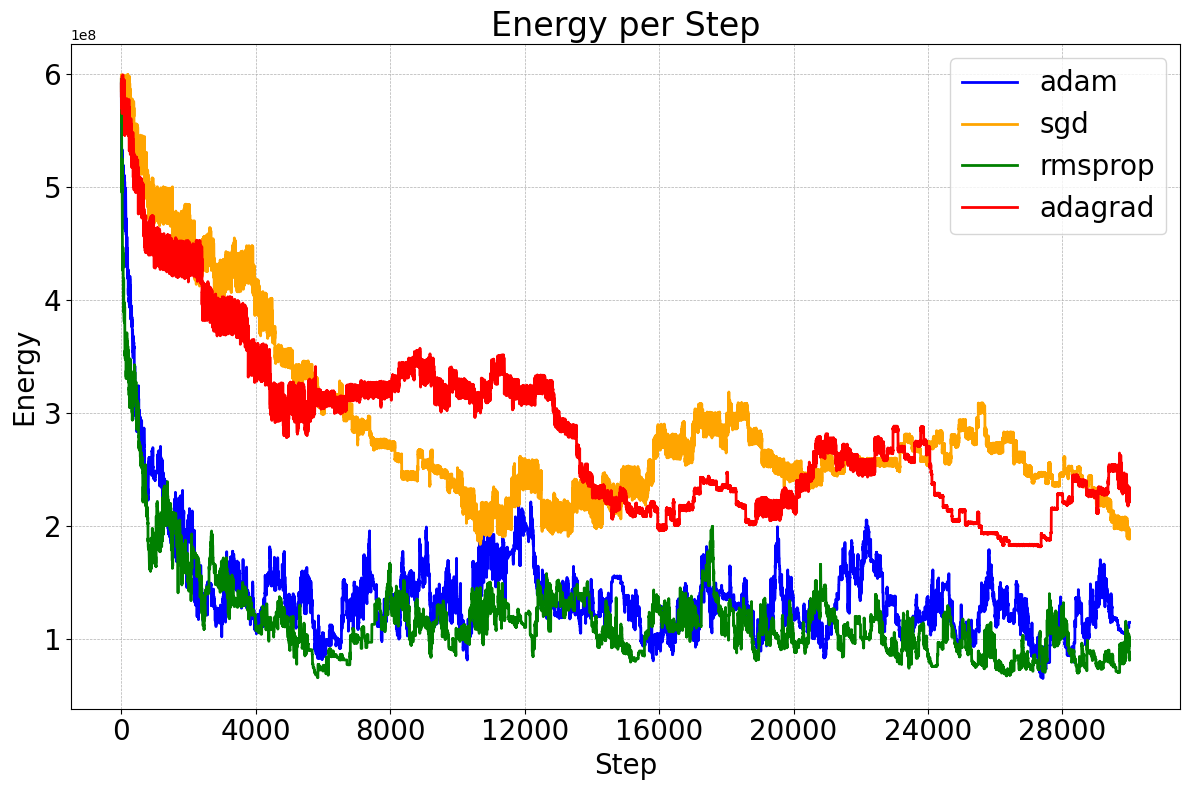

In [ ]:
plot_least_combined_episode(optimizer_results, num_episodes, 'Delay', 60000000)

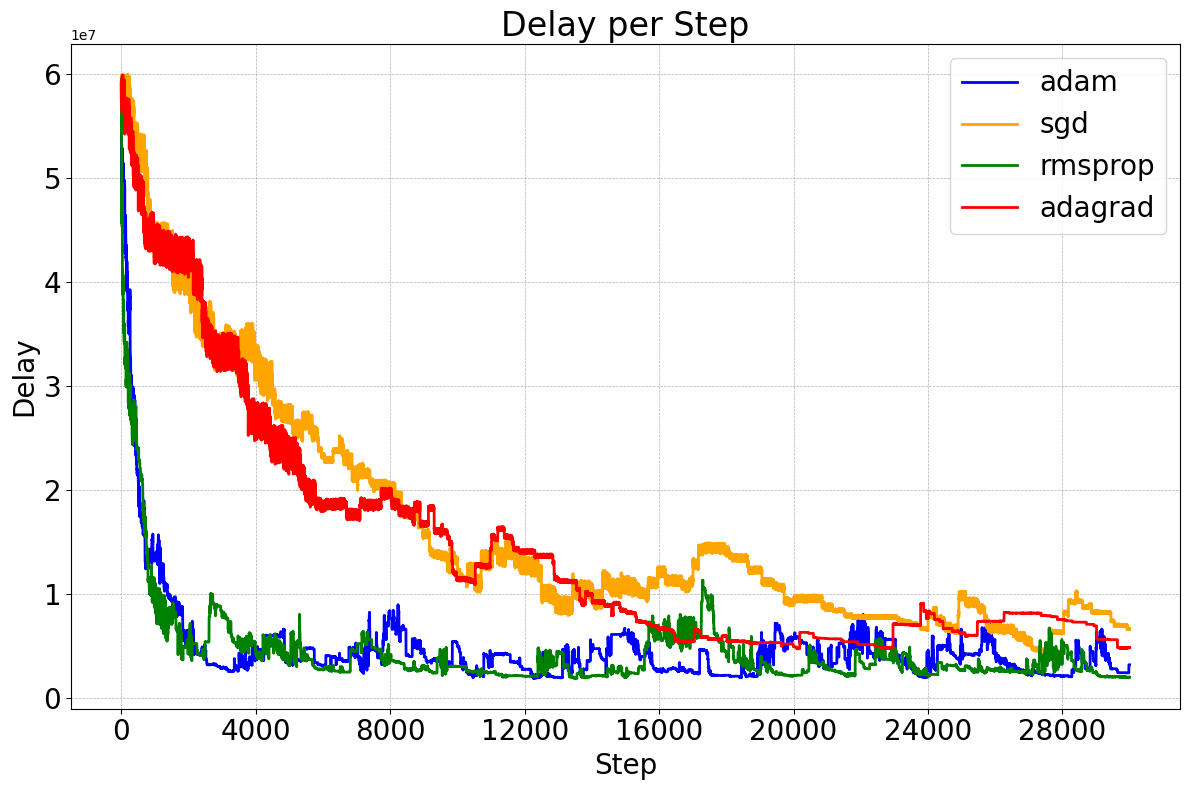

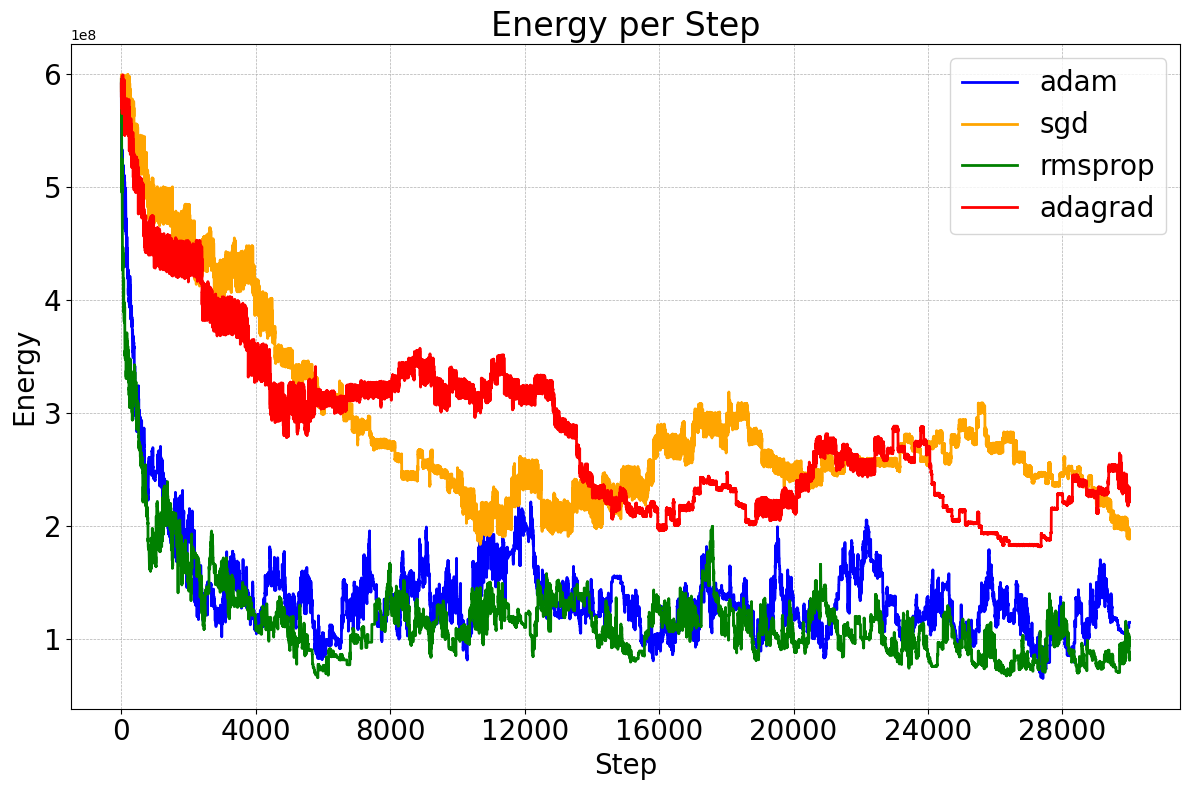

In [ ]:
plot_least_combined_episode(optimizer_results, num_episodes, 'Energy', 600000000)

In [ ]:
# Print final statistics
for optimizer, data in optimizer_results.items():
    print(f"\nOptimizer: {optimizer}")
    print(f"Final Average Reward: {data['rewards'][-1]:.2f}")
    print(f"Final Average Delay: {data['delays'][-1]:.2f}")
    print(f"Final Average Energy: {data['energy'][-1]:.2f}")


Optimizer: adam
Final Average Reward: 24.59
Final Average Delay: 6194904.33
Final Average Energy: 150552880.18

Optimizer: sgd
Final Average Reward: 23.60
Final Average Delay: 15363652.21
Final Average Energy: 313229776.39

Optimizer: rmsprop
Final Average Reward: 24.97
Final Average Delay: 3963842.51
Final Average Energy: 123362775.48

Optimizer: adagrad
Final Average Reward: 23.78
Final Average Delay: 14165697.18
Final Average Energy: 279010438.22
